In [1]:
import segar

In [2]:
from typing import Optional, Tuple

from gym.spaces import Discrete
from IPython.display import Image
from matplotlib.pyplot import imshow
import numpy as np
import PIL

from segar.rules.transitions import TransitionFunction, Aggregate, Differential
from segar.factors import (
    Position,
    Velocity,
    Acceleration,
    Size,
    Mass,
    NumericFactor,
    Mobile, Label, Text, Shape, Circle, FACTORS, Force
)
from segar.mdps.initializations import Initialization
from segar.mdps.mdps import MDP
from segar.mdps.observations import ObjectStateObservation
from segar.mdps.tasks import Task
from segar.parameters import Gravity
from segar.rendering.rgb_rendering import RGBRenderer, register_rule
from segar.sim import change_precision, Simulator
from segar.tools.sample_trajectories import rollout_sim_only, rollout, save_gif
from segar.things import Entity, Object, SquareWall, Ball, Thing


change_precision(0.01) # Because changing the size makes collision checks a bit less precise

/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay
/Users/rdevonhjelm/Code/segar/segar/factors/shapes.py:26: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, Delaunay


In [3]:
class Angle(NumericFactor[float], default=0., range=[-float(np.pi) / 2., float(np.pi) / 2.]):
    pass


class AngularVelocity(NumericFactor[float], default=0., range=[-float(np.pi), float(np.pi)]):
    pass


class AngularAcceleration(NumericFactor[float], default=0.):
    pass


class PoleMassProp(Mass, range=[0., 1.], default=0.1):
    pass


class PoleLength(NumericFactor[float], default=1.):
    pass


@TransitionFunction
def change_angle(theta: Angle, v: AngularVelocity) -> Differential[Angle]:
    dtheta = v
    return Differential[Angle](theta, dtheta)


@TransitionFunction
def change_angular_velocity(thetavel: AngularVelocity, thetaacc: AngularAcceleration) -> Differential[AngularVelocity]:
    dthetavel = thetaacc
    return Differential[AngularVelocity](thetavel, thetaacc)


@TransitionFunction
def change_angular_acceleration(o_factors: Tuple[Mass, Velocity, PoleMassProp, PoleLength, Acceleration, Angle, AngularVelocity, AngularAcceleration], gravity: Gravity
                               ) -> Tuple[Aggregate[AngularAcceleration], Aggregate[Acceleration]]:
    total_mass, vel, pole_prop_mass, length, acceleration, theta, thetavel, thetaacc = o_factors

    if abs(theta) >= np.pi / 2.:
        # This is pretty much game over for carpole, but if we want cartpole physics that work past when the episode normally ends, we need to stop theta
        return None
    a_y = acceleration[1]
    pole_mass = total_mass * pole_prop_mass
    force = a_y * total_mass
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    
    # Copied more or less from gym
    temp = (force + length * thetavel ** 2 * sintheta) / total_mass
    dthetavel = (gravity * sintheta - costheta * temp) / (length * (4.0 / 3.0 - pole_mass * costheta ** 2 / total_mass))

    # Here we need to remove the external force because it's already being applied to the ball
    da_y = temp - length * dthetavel * costheta / total_mass - force / total_mass
    
    return Aggregate[AngularAcceleration](thetaacc, dthetavel), Aggregate[Acceleration](acceleration, [0., da_y])


def color_map(thing: Thing):
    if not thing.has_factor(Angle):
        return None
    
    theta = thing[Angle]
    c = round((theta + float(np.pi / 2.)) * 255 / float(np.pi))
    color = [c, 0, 255 - c]
    return color


register_rule(color_map)


class CartPole(Ball, default={Shape: Circle(0.2), Mobile: True, Label: "cartpole", Text: "C"}):
    _factor_types = Object._factor_types + (Angle, AngularVelocity, AngularAcceleration, PoleMassProp, PoleLength)
    
first_factors = [ft for ft in FACTORS if ft not in (Velocity, AngularVelocity, Position, Angle, Force)]
sim = Simulator(factor_update_order=(first_factors[:], [Force, Velocity, AngularVelocity], [Angle]))
sim.add_rule(change_angle)
sim.add_rule(change_angular_velocity)
sim.add_rule(change_angular_acceleration)

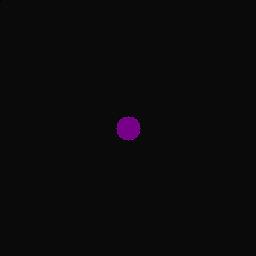

In [4]:
sim.reset()
cartpole = CartPole(initial_factors={Angle: -0.1})
sim.adopt(cartpole)
renderer = RGBRenderer(annotation=False, reset_every_call=True)
renderer.reset(sim)
trajectories, imgs = rollout_sim_only(sim, renderer=renderer, n_steps=200)

save_gif(imgs, out_path='trajectory_sample.gif')
Image(open('trajectory_sample.gif','rb').read())

In [5]:
_Y_ACTIONS = [-1., 1.]

class CartPoleInitialization(Initialization):

    def __call__(self, init_things: Optional[list[Entity]] = None) -> None:
        cartpole = CartPole(initial_factors={Angle: 0.01})
        sim.adopt(cartpole)

        
class CartPoleTask(Task):

    def __init__(
        self,
        initialization: Initialization,
        x_actions: list[float] = _Y_ACTIONS,
        baseline_action: int = 0
    ):

        self._sim = None
        self._actions = x_actions
        self._action_space = Discrete(len(x_actions))
        self._initialization = initialization
        self._baseline_action = baseline_action

    @property
    def action_space(self) -> Discrete:
        return self._action_space

    def check_action(self, action: int) -> bool:
        return action in list(range(len(self._actions)))

    def demo_action(self) -> int:
        return 1 # Do nothing

    def apply_baseline(self, action: int) -> int:
        self.check_action(action)
        action += self._baseline_action
        return action

    def reward(self, state: dict) -> float:
        theta = state['things'][0][Angle]
        return float(np.abs(theta) <= np.pi / 2.)

    def apply_action(self, action: int) -> None:
        self.sim.add_force(0, np.array([0., self._actions[action]]))

    def done(self, state: dict) -> bool:
        return False

    def sample(self) -> None:
        pass

    def results(self, state: dict) -> dict:
        """Returns results to be processed by the MDP.
        :param state: State dictionary to pull results from.
        :return: Dictionary of results.
        """
        return {}

/Users/rdevonhjelm/miniconda3-x86/envs/segar/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


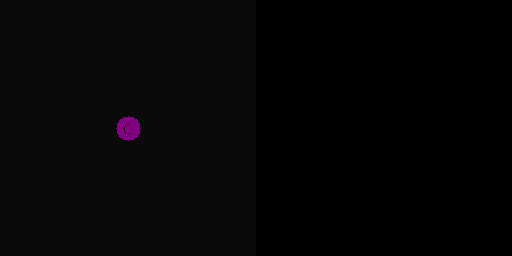

In [7]:
initialization = CartPoleInitialization()
cartpole = CartPoleTask(initialization)
observations = ObjectStateObservation(0)
mdp = MDP(observations, cartpole, reset_renderer_every_call=True)
imgs, trajectories = rollout(mdp)

save_gif(imgs, out_path='cartpole.gif')
Image(open('cartpole.gif','rb').read())